### Importing the required libraries ###

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import zipfile


### UNZIP files ###

In [2]:
# Will unzip the files so that you can see them..
with zipfile.ZipFile("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip","r") as z:
    z.extractall(".")


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/__notebook_source__.ipynb
/kaggle/working/train.csv


### Reading the Train File ###

In [4]:
# prepare text samples and their labels
print('Loading in comments...')

data = pd.read_csv("/kaggle/working/train.csv")
print(data.head())

Loading in comments...
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [5]:
# Feature Imformation 
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [6]:
# Data Dimension 

data.shape 

(159571, 8)

In [7]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [8]:
# Check Missing Value 

print(data["comment_text"].isna().sum())

# dropna 

0


In [9]:
# check missing values in numeric columns
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
unlabelled_in_all = data[(data['toxic']!=1) & (data['severe_toxic']!=1) &
                             (data['obscene']!=1) & (data['threat']!=1) &
                             (data['insult']!=1) & (data['identity_hate']!=1)]
print('Percentage of unlabelled comments or good comments is ', len(unlabelled_in_all)/len(data)*100)

Percentage of unlabelled comments or good comments is  89.83211235124176


In [11]:
labelled_in_all = data[(data['toxic']==1) & (data['severe_toxic']==1) &
                             (data['obscene']==1) & (data['threat']==1) &
                             (data['insult']==1) & (data['identity_hate']==1)]
print('Percentage of comments which is present in all categories is ', len(labelled_in_all)/len(data)*100)

Percentage of comments which is present in all categories is  0.019427088882065038


In [12]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in train is {}'.format(len(data)))
print(data[cols_target].sum())

Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


Next, let's examine the correlations among the target variables.

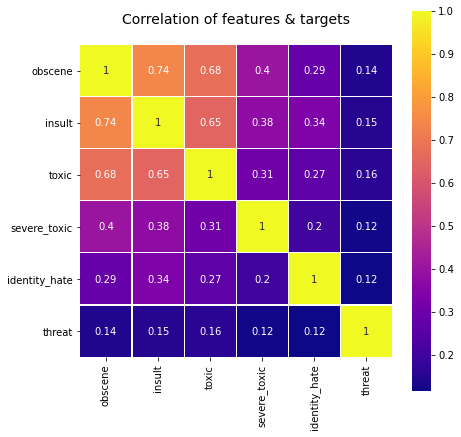

In [13]:
target_data = data[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(target_data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

### Now this kind of problem is ###

1) Multi class problem and not Binary

2) Also all classes are not independent but rather dependent or correlated 

3) A comment can belong to multiple classes at the same time for e.g. comment can be toxic and insulting at the same time

Let us simplify the problem by first classifying the comments as "block" vs "allow" 

In [42]:
data['block'] =data[cols_target].sum(axis =1)

data['block'] = data['block'] > 0 
data['block'] = data['block'].astype(int)
data['block'].value_counts()


0    143346
1     16225
Name: block, dtype: int64

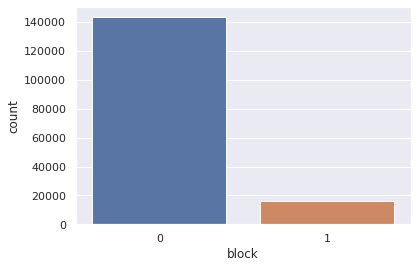

In [15]:
# look at the count plot for text length
sns.set()
sns.countplot(x="block" , data = data )
plt.show()

In [16]:
# Event Rate 

print("Percentage Event Rate : " , round(100*data['block'].sum()/data.shape[0],2) , "%")

Percentage Event Rate :  10.17 %


### Let us focus on comments  ###

In [17]:
# Let's look at the character length for the rows in the training data and record these
data['char_length'] = data['comment_text'].apply(lambda x: len(str(x)))

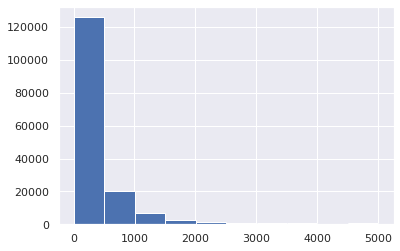

In [18]:
# look at the histogram plot for text length
sns.set()
data['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.



### Clean the Comments Text ###

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [20]:
%%time 
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
data['comment_text'] = data['comment_text'].map(lambda com : clean_text(com))

CPU times: user 16.4 s, sys: 110 ms, total: 16.5 s
Wall time: 16.5 s


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['comment_text'], data['block'], test_size=0.2, random_state=42)

In [46]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(127656,) (31915,)
(127656,) (31915,)


In [53]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features = 10000, stop_words='english')
print(vect)

TfidfVectorizer(max_features=10000, stop_words='english')


In [54]:
%%time 
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_dtm

CPU times: user 11.2 s, sys: 66.9 ms, total: 11.3 s
Wall time: 11.3 s


<127656x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2792162 stored elements in Compressed Sparse Row format>

In [52]:
3222899/ (127656*165867)

0.00015221080188127105

In [56]:
%%time
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_dtm = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_dtm

CPU times: user 2.73 s, sys: 1 ms, total: 2.73 s
Wall time: 2.73 s


<31915x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 688258 stored elements in Compressed Sparse Row format>

## Lets us build a binary classifier using Logistic Regression ##

In [57]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
logreg = LogisticRegression(C=1, max_iter = 2000)



# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = logreg.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))


Training accuracy is 0.9594613649182178
Test accuracy is 0.9563214789284036
[[28507   164]
 [ 1230  2014]]


# Welcome to the curse of Accuracy, F1(help) to the rescue #

In [60]:
from sklearn.metrics import f1_score


print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
    


F1 score on Test data :  0.7428992991516045


### In case of Class Imbalance - we use F1 score as a general measure for the model performance ###

Depending on the Business case - we need to fine tune the model 

There is a Precision vs Recall Trade off 

If you want to capture all toxic tweets  - then some of the good twwets will be misclassified as bad tweets 

In [77]:
y_pred_test = logreg.predict_proba(X_test_dtm)[:,1]
#print(y_pred_test)
y_pred_test = y_pred_test >= 0.2 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.9515588281372396
[[27777   894]
 [  652  2592]]
F1 score on Test data :  0.7702823179791977


# Let us use a tree base model #

In [62]:
%%time 

from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier 

dt_clf = DecisionTreeClassifier()
# train the model using X_train_dtm & y_train
dt_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = dt_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = dt_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9987701322303691
Test accuracy is 0.9421588594704684
[[27824   847]
 [  999  2245]]
F1 score on Test data :  0.7086489898989898
CPU times: user 6min 15s, sys: 54.1 ms, total: 6min 15s
Wall time: 6min 15s


### Lets us try an Ensemble of Trees ###

In [63]:
%%time 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 

rf_clf = RandomForestClassifier()

# train the model using X_train_dtm & y_train
rf_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = rf_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = rf_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.998730964467005
Test accuracy is 0.9579821400595331
[[28307   364]
 [  977  2267]]
F1 score on Test data :  0.7717446808510637
CPU times: user 9min 2s, sys: 86.1 ms, total: 9min 3s
Wall time: 9min 3s


In [79]:
# Fine Tuning Random Forest 

y_pred_test = rf_clf.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.05 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.8115619614601285
[[22865  5806]
 [  208  3036]]
F1 score on Test data :  0.5023994704616912


In [65]:
%%time
from sklearn.metrics import f1_score
from sklearn.linear_model  import PassiveAggressiveClassifier 

pa_clf = PassiveAggressiveClassifier()

# train the model using X_train_dtm & y_train
pa_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = pa_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = pa_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9745722880240647
Test accuracy is 0.9551308162306126
[[28157   514]
 [  918  2326]]
F1 score on Test data :  0.7646285338593032
CPU times: user 914 ms, sys: 18 ms, total: 932 ms
Wall time: 637 ms


### Passive Aggresive Classifier does not support prediction probability - so can't be fined ###

In [66]:
%%time 
from sklearn.metrics import f1_score
import xgboost 

xgb = xgboost.XGBClassifier()
# train the model using X_train_dtm & y_train
xgb.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = xgb.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = xgb.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9605032274237012
Test accuracy is 0.9544414851950493
[[28513   158]
 [ 1296  1948]]
F1 score on Test data :  0.7282242990654205
CPU times: user 2min 18s, sys: 955 ms, total: 2min 19s
Wall time: 38.4 s


In [67]:
# Fine Tuning XGBOOST

y_pred_test = xgb.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.06 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.8847877173742754
[[25405  3266]
 [  411  2833]]
F1 score on Test data :  0.6064433265546398


### Advance Models - LightGBM ### 

In [68]:
import lightgbm 

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

train_data = lightgbm.Dataset(X_train_dtm, label=y_train)
test_data = lightgbm.Dataset(X_test_dtm, label=y_test)

clf = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=500,
                       early_stopping_rounds=10)






[1]	valid_0's auc: 0.783092
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.84214
[3]	valid_0's auc: 0.861219
[4]	valid_0's auc: 0.874613
[5]	valid_0's auc: 0.877839
[6]	valid_0's auc: 0.884924
[7]	valid_0's auc: 0.889691
[8]	valid_0's auc: 0.890547
[9]	valid_0's auc: 0.893395
[10]	valid_0's auc: 0.892991
[11]	valid_0's auc: 0.893584
[12]	valid_0's auc: 0.894835
[13]	valid_0's auc: 0.895268
[14]	valid_0's auc: 0.895774
[15]	valid_0's auc: 0.895769
[16]	valid_0's auc: 0.896405
[17]	valid_0's auc: 0.897059
[18]	valid_0's auc: 0.897579
[19]	valid_0's auc: 0.899455
[20]	valid_0's auc: 0.900329
[21]	valid_0's auc: 0.901626
[22]	valid_0's auc: 0.902794
[23]	valid_0's auc: 0.903408
[24]	valid_0's auc: 0.904566
[25]	valid_0's auc: 0.906046
[26]	valid_0's auc: 0.90721
[27]	valid_0's auc: 0.907912
[28]	valid_0's auc: 0.907802
[29]	valid_0's auc: 0.908702
[30]	valid_0's auc: 0.908989
[31]	valid_0's auc: 0.909595
[32]	valid_0's auc: 0.909745
[33]	valid_0's auc: 0.

[277]	valid_0's auc: 0.956792
[278]	valid_0's auc: 0.956803
[279]	valid_0's auc: 0.956883
[280]	valid_0's auc: 0.95693
[281]	valid_0's auc: 0.956964
[282]	valid_0's auc: 0.957007
[283]	valid_0's auc: 0.957083
[284]	valid_0's auc: 0.95707
[285]	valid_0's auc: 0.957124
[286]	valid_0's auc: 0.957207
[287]	valid_0's auc: 0.957244
[288]	valid_0's auc: 0.957306
[289]	valid_0's auc: 0.957349
[290]	valid_0's auc: 0.957408
[291]	valid_0's auc: 0.957445
[292]	valid_0's auc: 0.957502
[293]	valid_0's auc: 0.95758
[294]	valid_0's auc: 0.957599
[295]	valid_0's auc: 0.957609
[296]	valid_0's auc: 0.957614
[297]	valid_0's auc: 0.957632
[298]	valid_0's auc: 0.957682
[299]	valid_0's auc: 0.957702
[300]	valid_0's auc: 0.957733
[301]	valid_0's auc: 0.957814
[302]	valid_0's auc: 0.957865
[303]	valid_0's auc: 0.957903
[304]	valid_0's auc: 0.957921
[305]	valid_0's auc: 0.95791
[306]	valid_0's auc: 0.95795
[307]	valid_0's auc: 0.957935
[308]	valid_0's auc: 0.957934
[309]	valid_0's auc: 0.957971
[310]	valid_0's

In [69]:
# Fine Tuning LIGHT GBM

y_pred_test = clf.predict(X_test_dtm)
y_pred_test = y_pred_test >= 0.35 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.8930910230299233
[[25598  3073]
 [  339  2905]]
F1 score on Test data :  0.6300151810887009


## Model Explanation ##

In [70]:
import eli5

eli5.show_weights(logreg,vec = vect, top = 15)  # logistic regression
# will give you top 15 features or words  which makes a comment toxic 

Weight?,Feature
+16.643,fuck
+13.475,fucking
+12.117,shit
+11.670,idiot
+11.024,stupid
+10.370,ass
+9.229,asshole
+8.903,bullshit
+8.776,suck
+8.692,bitch


In [71]:
eli5.show_weights(xgb,vec = vect,top = 15)  # XGBoost
# will give you top 15 features or words  which makes a comment toxic 

Weight,Feature
0.0273,fuck
0.0153,fucking
0.0128,faggot
0.0128,dick
0.0126,suck
0.0114,asshole
0.0105,penis
0.0105,fat
0.0103,bitch
0.0102,shit


## Tweets Explanation ##

In [72]:
X_test.iloc[718]

'by the way the exchange between rjensen is jpgordon is a sock puppet conversation pathetic really 129 133 127 244'

In [73]:
eli5.show_prediction(logreg, vec = vect, doc =  X_test.iloc[718]) 